In [4]:
from fastai.vision import *

## Get a list of URLs

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

1.urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);

2.window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [26]:
folder = 'black_bears'
file = 'urls_black_bear.csv'

In [13]:
folder = 'lupus_lupus'
file = 'urls_lupus_lupus.csv'

In [27]:
#Creating the folder to the dataset 
path = Path('data/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [28]:
path.ls()

[PosixPath('data/animals/urls_black_bear.csv'),
 PosixPath('data/animals/urls_lupus_lupus.csv'),
 PosixPath('data/animals/lupus lupus'),
 PosixPath('data/animals/.ipynb_checkpoints'),
 PosixPath('data/animals/black_bears')]

In [29]:
classes = ['black_bears','lupus_lupus']

In [30]:
download_images(path/file,dest,max_pics=200)

In [46]:
#Remove any images that can't be opened
for c in classes:
    print(c)
    verify_images(path/c,delete=True,max_size=500)

In [47]:
torch.cuda.set_device(3)
bs=128 #how many images to train at the same time

In [48]:
data=ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,ds_tfms=get_transforms(),size=224,num_workers=8).normalize(imagenet_stats)

In [49]:
data.classes

['black_bears', 'lupus_lupus']

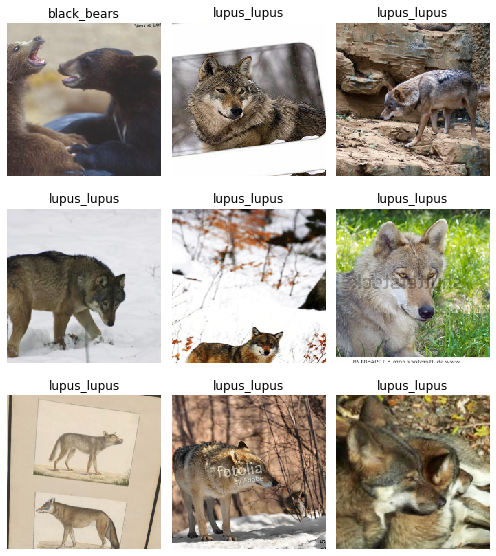

In [50]:
data.show_batch(rows=3,figsize=(7,8))

In [54]:
data.classes,data.c,len(data.train_ds),len(data.valid_ds)

(['black_bears', 'lupus_lupus'], 2, 220, 54)

## Train model

In [70]:
learn=cnn_learner(data,models.resnet34,metrics=error_rate)

In [73]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.699753,0.272076,0.111111,00:02
1,0.405348,0.060718,0.018519,00:02
2,0.271967,0.051403,0.018519,00:02
3,0.202865,0.048287,0.018519,00:02


In [74]:
learn.save('stage-1')

In [75]:
learn.unfreeze()

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


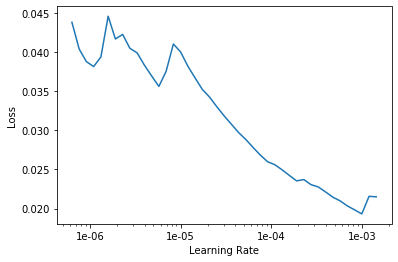

In [77]:
learn.recorder.plot()

In [79]:
learn.fit_one_cycle(2,max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.142938,0.367887,0.092593,00:02
1,0.131205,0.027342,0.018519,00:02


In [81]:
learn.save('stage-2')

### Interpreation 

In [83]:
learn.load('stage-2');

In [84]:
interp=ClassificationInterpretation.from_learner(learn)

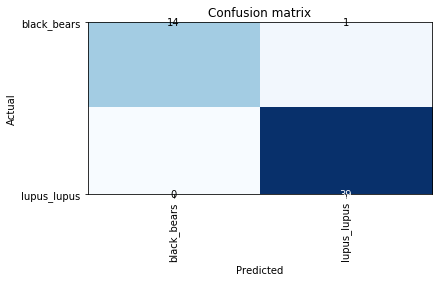

In [85]:
interp.plot_confusion_matrix()

### Cleaning up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

In [86]:
from fastai.widgets import *

In [90]:
db=(ImageList.from_folder(path)
                    .split_none()
                    .label_from_folder()
                    .transform(get_transforms(),size=224)
                    .databunch()

   )

In [94]:
learn_cln=cnn_learner(db,models.resnet34,metrics=error_rate)

In [96]:
learn_cln.load('stage-2');

In [97]:
ds,idxs = DatasetFormatter().from_toplosses(learn_cln) 

In [98]:
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [99]:
ds,idxs=DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [101]:
ImageCleaner(ds,idxs,path,duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Putting your model in production

In [102]:
learn.export()

In [103]:
learn=load_learner(path)